# Regresión lineal y Gradient Descent
Hemos obtenido unos datos de gran potencial: ¡el histórico de sobornos de la universidad! Para cada soborno ofrecido por un alumno, sabemos la nota que finalmente obtuvo en la asignatura.
Esto es muy interesante porque podemos predecir cuánto dinero tenemos que pagar para obtener cierta nota (sin derrochar dinero). Por ejemplo, **¿cuánto debería pagar para obtener un 6.9?**

En esta sección construiremos un modelo de regresión lineal de cero para saber cuánto pagar (variable x) para obtener cierta nota (variable y). Es decir, un modelo del tipo:

$y = \beta_0 + \beta_1 \cdot x$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

df = pd.read_csv("data/sobornos.csv")

# plot the data on df, sobornos is x, notas y and sexo color
df.plot.scatter(x='notas', y='sobornos')

x_data = df['notas'].values
y_data = df['sobornos'].values


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
  File "c:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.init_signal()
  File "c:\ProgramData\anaconda3\Lib\site-packages\tornado\platform\asyncio.py

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: initialization failed

Observando los datos, podemos hacer una estimación razonable de los valores de $\beta_0$ y $\beta_1$:
$$y = 1.25 + (3 - 1) / 10 * x$$

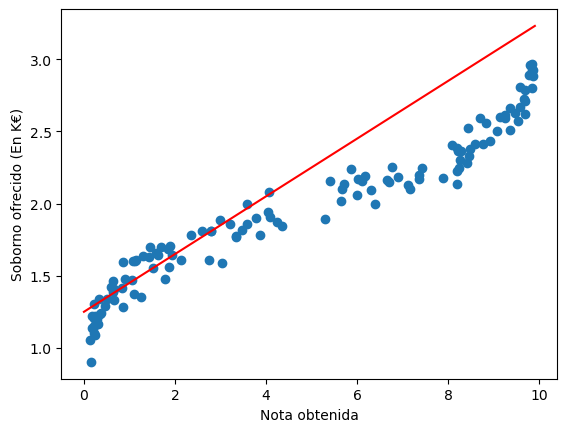

In [3]:
xs = np.arange(0, 10, 0.1)
# prueba a ajustar los valores a mano
y_preds = 1.25 + 0.2 * xs

plt.scatter(x_data, y_data)
plt.plot(xs, y_preds, c='red')
plt.xlabel("Nota obtenida")
plt.ylabel("Soborno ofrecido (En K€)")
plt.show()

Hay varios problemas con la aproximación que estás probando:
1. Estás eligiendo los **parámetros de tu modelo** a mano.
2. Evaluar el rendimiento de tu modelo en base a gráficos es difícil y tiene cierto componente subjetivo.

Pare resolver estos problemas:
1. Queremos que una máquina elija los parámetros por nosotros. Esto es el **aprendizaje automático (machine learning o ML)**. Nuestros modelos van a evolucionar a **modelos de ML**, en los que los parámetros se aprenden de forma
automática.

![](https://drek4537l1klr.cloudfront.net/trask2/Figures/f0015-01.jpg)

2. Para que los modelos se puedan "auto-configurar", necesitamos una **métrica** que indique al modelo cómo de bien esta resolviendo la tarea.

Generalmente, las métricas en ML se conocen como 🧂**loss functions**🧂. Como su nombre indica, nos interesa que sean lo más pequeñas posibles. (el 🧂 indica que este es un ingrediente clave del ML).

En el contexto de nuestro problema de regresión, sabemos que una loss function adecuada es el **Mean Square Error** (MSE), que mide las distancias entre predicciones y los datos reales.

In [4]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# de nuevo, prueba a ajustar los coeficientes pare reducir el error
y_preds =  1.25 + 0.2 * x_data
print(mean_squared_error(y_data, y_preds))


0.1152540234260375


Ahora que tenemos loss function, **¿cómo hacer que los coeficientes se ajusten automáticamente?**

Antes de meternos a fondo, convirtamos a nuestro modelo en algo similar a lo que tendríamos en Sklearn:



In [5]:
from sklearn.base import RegressorMixin, BaseEstimator

class MyLinearRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, initial_beta_0=1.5, initial_beta_1=0.2):
        super().__init__()
        self.beta_0 = initial_beta_0
        self.beta_1 = initial_beta_1

    def fit(self, X, y):
        # ???????
        pass

    def predict(self, X):
        return self.beta_0 + self.beta_1 * X
    


Recordemos que el objetivo que tenemos en mente es elegir (de forma automática), un valor para las variables `beta_0` y `beta_1` de nuestro. Por el momento, y por sencillez, imaginemos que `beta_0` está fijado y que tan solo queremos ajustar `beta_1`. Dado que nos hemos molestado en escribir `mean_squared_error`, una forma tentadora de hacerlo es probar muchos valores y quedarse con el de menor MSE:

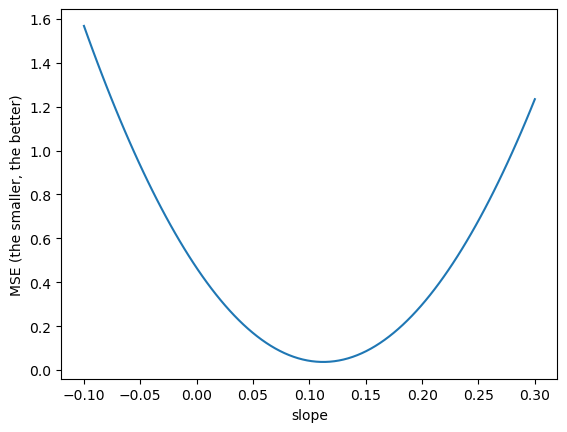

In [6]:
errores = []
slopes = np.linspace(-0.1, 0.3, 100)
for slope in slopes:
  test_model = MyLinearRegressor(initial_beta_1=slope)
  error = mean_squared_error(y_data, test_model.predict(x_data))
  errores.append(error)

plt.plot(slopes, errores)
plt.xlabel("slope")
plt.ylabel("MSE (the smaller, the better)")
plt.show()


Aunque esto resuelve el problema, es una aproximación muy ineficiente dado que hemos vuelto a probar todos los valores. Reformulemos ligeramente el problema.
**Dado un valor inicial para la pendiente, ¿cómo puedo elegir un mejor valor con una sola "prueba"?**

Modelo con pendiente inicial 0.26 tiene un MSE de 0.815
Modelo con pendiente inicial -0.08 tiene un MSE de 1.291


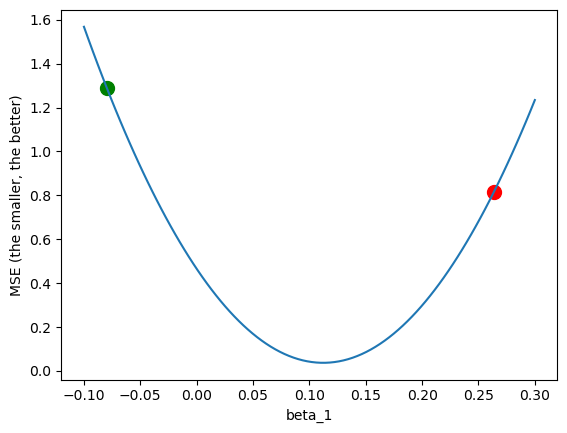

In [7]:
red_slope, red_mse = slopes[90], errores[90]
green_slope, green_mse = slopes[5], errores[5]


def represent_red_green_models(red_slope, green_slope, red_mse, green_mse):
    print(f"Modelo con pendiente inicial {red_slope:.2f} tiene un MSE de {red_mse:.3f}")
    print(f"Modelo con pendiente inicial {green_slope:.2f} tiene un MSE de {green_mse:.3f}")
    
    plt.plot(slopes, errores)
    plt.scatter(red_slope, red_mse, c='r', s=100)
    plt.scatter(green_slope, green_mse, c='g', s=100)
    plt.xlabel("beta_1")
    plt.ylabel("MSE (the smaller, the better)")
    plt.show()
    
represent_red_green_models(red_slope, green_slope, red_mse, green_mse)

¡La clave está en las **derivadas**, o de forma más genérica, en los **gradientes**! Los gradientes nos dicen cuál es el ritmo de cambio de una función (en nuestro caso, MSE) con respecto a un parámetro ($\beta_1$). De forma indirecta, esto nos dirá hacia dónde nos debemos mover para mejorar el valor actual del MSE actual. 

Vayamos por pasos: calculemos la derivada para nuestra loss function con respecto a nuestro parámetro $\beta_1$:
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2$$
$$\frac{dMSE}{d\beta_1} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i)) x_i$$

Volviendo a nuestro ejemplo, podemos evaluar la derivada del "modelo rojo" y del "modelo verde" (también repintaremos la gráfica por comodidad):

La derivada del modelo rojo es 10.29
La derivada del modelo verde -13.05
********************************************************************************
Modelo con pendiente inicial 0.26 tiene un MSE de 0.815
Modelo con pendiente inicial -0.08 tiene un MSE de 1.291


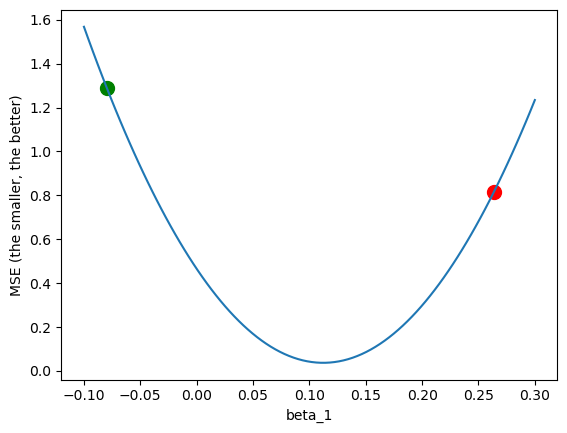

In [8]:
def grad(beta_0, beta_1):
    preds = beta_0 + beta_1 * x_data
    return -2 * np.mean(
        (y_data - preds) * x_data
    )

# All models used the same beta_0
beta_0 = test_model.beta_0
red_derivative = grad(beta_0, red_slope)
green_derivative = grad(beta_0, green_slope)

print(f"La derivada del modelo rojo es {red_derivative:.2f}")
print(f"La derivada del modelo verde {green_derivative:.2f}")
print("*" * 80)
represent_red_green_models(red_slope, green_slope, red_mse, green_mse)

Hemos obtenido que:
* La derivada en el punto rojo es positiva -> ¡claro! La función es creciente.
* La derivada en el punto verde es negativa -> ¡claro! La función es decreciente.

Por tanto, podemos interpretar el signo de la derivada de la siguiente forma:
* Si la derivada es positiva, esto nos indica que debemos movernos hacia la derecha para aumentar el valor de la función.
* Si la derivada es negativa, esto nos indica que debemos movernos hacia la izquierda para aumentar el valor de la función.

Es decir, **la derivada (gradiente) nos indica hacia dónde debemos movernos para aumentar el valor de la función** (Comprueba esto en el gráfico.). La magnitud de la derivada nos indica cuánto va a cambiar el valor del MSE si nos movemos en la dirección indicada por la derivada (gradiente).

Dado que queremos minimizar el valor de la *loss function*, la receta para lograr el aprendizaje automático de parámetros se puede resumir en **<<debemos movernos en la dirección contraria a la indicada por el derivada (gradiente)>>**.

En nuestro modelo, esto significa que podemos actualizar el parámetro `slope` usando algo similar a:
$$\text{slope} ← \text{slope} - \epsilon \cdot \text{gradient}$$

Donde $\epsilon$ es un número pequeño conocido como **learning rate** que asegura que damos pasitos pequeños. A esta regla de actualización de parámetros se la conoce como **Gradient Descent**.

Pongámoslo en práctica:


In [9]:
from sklearn.base import RegressorMixin, BaseEstimator

class MyLinearRegressor(RegressorMixin, BaseEstimator):
    # Learning rate should be small to move in small steps. Typical values range between [1e-5, 1e-5]
    def __init__(self, initial_beta_0=1.5, initial_beta_1=0.3, 
                 learning_rate=1e-3, n_epochs=40, epoch_callback=None):
        super().__init__()
        self.beta_0 = initial_beta_0
        self.beta_1 = initial_beta_1
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.callback = epoch_callback

    def fit(self, X, y):
        def compute_grad():
            preds = self.beta_0 + self.beta_1 * X
            return -2 * np.mean(
                (y - preds) * X
            )
        for epoch in range(self.n_epochs):
            grad = compute_grad()
            self.beta_1 = self.beta_1 - self.learning_rate * grad
            if self.callback is not None:
                self.callback(epoch, self)
        return self
        
    def predict(self, X):
        return self.beta_0 + self.beta_1 * X
    

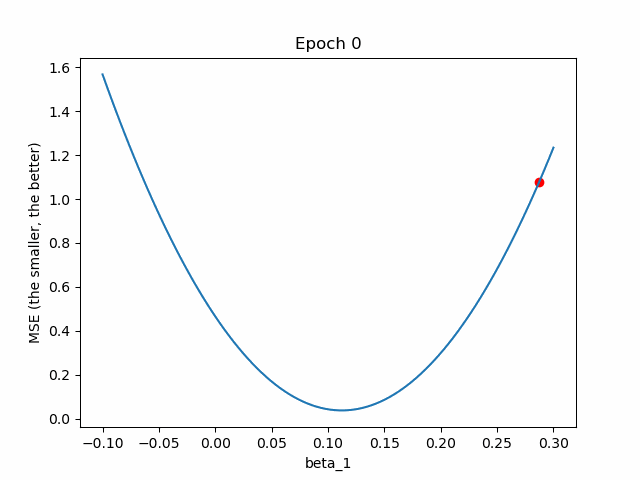

In [10]:
import imageio.v2 as imageio # For GIF generation
import tempfile 
import os

# This is not necessary, is just for visualization
class PlotCallback:
    def __init__(self, prefix=""):
        self.prefix = prefix
        self.images = []
        
    def __call__(self, epoch, model):
        plt.figure()
        plt.plot(slopes, errores)
        # x_data and y_data are captured from the global environment. 
        # Not great, but let it go for simplicity
        current_error = mean_squared_error(y_data, model.predict(x_data))
        plt.scatter(model.beta_1, current_error, c="red")
        plt.title(f"Epoch {epoch}")
        plt.xlabel("beta_1")
        plt.ylabel("MSE (the smaller, the better)")
        temp_dir = tempfile.gettempdir()
        filepath = os.path.join(
            temp_dir,
            f"{self.prefix}_{epoch}.png"
        )
        plt.savefig(filepath)
        plt.close()
        self.images.append(imageio.imread(filepath))
    
# Deactivate interactive mode
plt.ioff()  
# This code is slow due to the callback, which creates a gif for visualizing the 
# training dynamics
callback = PlotCallback()
linear_model = MyLinearRegressor(epoch_callback=callback)
linear_model.fit(x_data, y_data)
imageio.mimsave("gradient_descent.gif",
                callback.images, 
                duration=0.1, 
                loop=0)

# restore interactive mode
plt.ion()
from IPython.display import Image
Image(filename='gradient_descent.gif')


Comprovemos que, efectivamente, el algoritmo aprende correctamente haciendo predicciones:

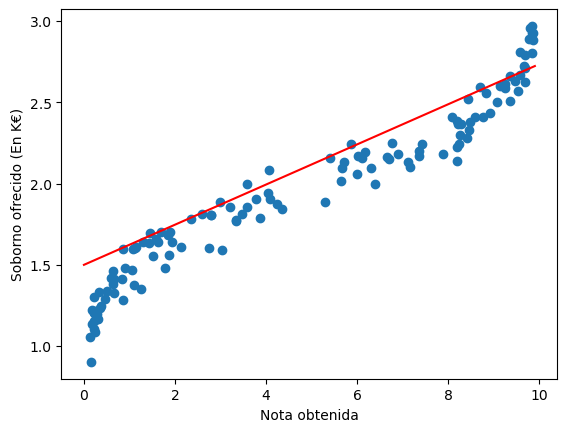

In [11]:
plt.scatter(x_data, y_data)
plt.plot(xs, linear_model.predict(xs), c='red')
plt.xlabel("Nota obtenida")
plt.ylabel("Soborno ofrecido (En K€)")
plt.show()

![](https://media.giphy.com/media/MS3XuWjQV1FiU/giphy.gif)

## Ejercicio: Influencia del learning rate en el aprendizaje
Usa el siguiente fragmento de código (adaptación del anterior) para visualizar cómo afecta el learning rate en el aprendizaje. Después, completa las siguientes frases:

* Si el learning rate es demasiado alto, entonces ...
* Si el learning rate es demasiado bajo, entonces ...

250


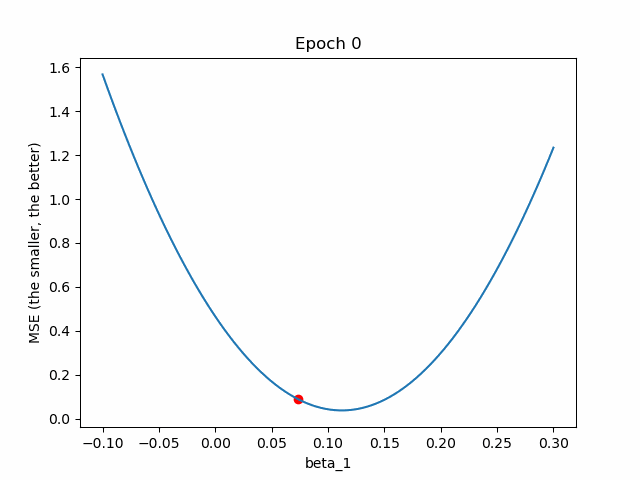

In [12]:
def check_lr(n_epochs, lr, initial_beta_1, duration=0.1):
    plt.ioff()
    callback = PlotCallback(prefix=str(lr))   
    try:
        linear_model = MyLinearRegressor(
            epoch_callback=callback, 
            learning_rate=lr,
            n_epochs=n_epochs,
            initial_beta_1=initial_beta_1
        )
        linear_model.fit(x_data, y_data)
    except: 
        pass
    gifname = f"lr_{str(lr)}.gif"
    print(duration)
    imageio.mimsave(gifname,
                    callback.images, 
                    duration=duration, 
                    loop=0)
    plt.ion()
    return gifname
    

# Very large learning rates 
gifname = check_lr(n_epochs=50, lr=0.03, initial_beta_1=0.15, duration=250)
Image(filename=gifname)

100


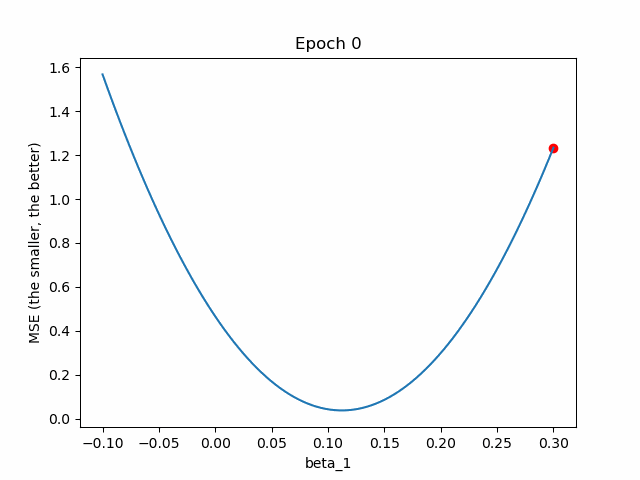

In [13]:

# Very small learning rates
gifname = check_lr(n_epochs=50, lr=1e-5, initial_beta_1=0.3, duration=100)
Image(filename=gifname)


# Regresión múltiple (con múltiples parámetros) y otras mejoras
En las celdas anteriores hemos implementado regresión lineal desde 0. **La única limitación importante es que nos hemos centrado en aprender un único parámetro ($\beta_1$).** 

Lo resolveremos y, más tarde, propondremos ejercicios de mejora.

Para motivar la creación de modelos de regresión múltiple, usaremos una variante del problema de los sobornos donde el sexo influye el resultado del soborno.  

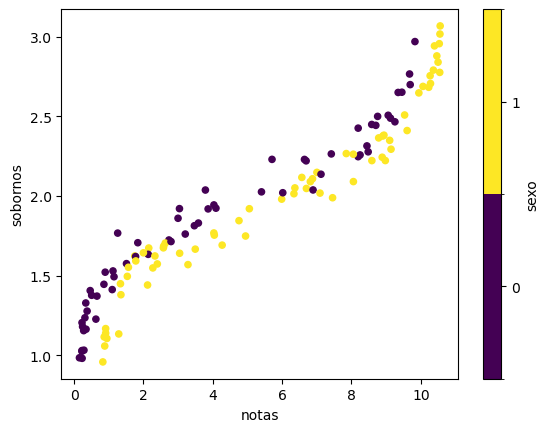

In [14]:
df = pd.read_csv("data/sobornos_completo.csv")
df["sexo"] = df["sexo"].astype("category")
# plot the data on df, sobornos is x, notas y and sexo color
df.plot.scatter(x='notas', y='sobornos', c='sexo', colormap='viridis')

x1_data = df['notas'].values
x2_data = df['sexo'].values
y_data = df['sobornos'].values

Por tanto, estamos buscando un modelo del tipo:
$$sobornos = \beta_0 + \beta_1 \cdot notas + \beta_2 \cdot sexo,$$
que escribiremos de forma más abstracta como:
$$y = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2,$$
$$(y = soborno; x_1 = notas; x_2 = sexo).$$ 

Recordemos que nuestro objetivo ahora es aprender todos los coeficientes: $\beta_0$, $\beta_1$ y $\beta_2$. Fijémonos en que la **ordenada en el origen** $\beta_0$ (o, en inglés, **intercept** o **bias**) parece especial, ya que no acompaña a ninguna variable del dataFrame. Con un truco de notación, podemos hacer que todos los coeficientes parezcan del mismo tipo. Definimos $x_0 = 1$ y escribimos:
$$y = \beta_0 \cdot x_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2.$$
Es decir, si nuestros datos son: 
| notas (x_1) | sexo (x_2) |
| ---------------- | ---------- |
| 1.67             | 1          |
| 2.69             | 0          |
| 1.63             | 1          |
| ...              | ...        |

Nosotros nos los imaginaremos como

| bias (x_0) | notas (x_1)    | sexo (x_2) |
|------------| ---------------- | ---------- |
| 1          | 1.67             | 1          |
| 1          | 2.69             | 0          |
| 1          | 1.63             | 1          |
| ...        | ...              | ...        |

De esta forma, además de hacer más similares a $\beta_0$ y las otras variables, podemos escribir la ecuación de regresión lineal de forma muy elegante:
$$\mathbf{y} = \mathbf{X} \mathbf{\beta}$$ 
donde $\mathbf{\beta} = [\beta_0, \beta_1, \beta_2]^T$,  
$\mathbf{y} = [y_1, y_2, \dots, y_n]^T$ es el vector de etiquetas,  
y $\mathbf{X}$ es la **matriz de diseño** con las características de los datos:
$$
\mathbf{X} = \begin{bmatrix}
1 & x_1^{(1)} & x_2^{(1)} \\
1 & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
1 & x_1^{(n)} & x_2^{(n)}
\end{bmatrix}.
$$

La principal novedad es que, ahora, queremos actualizar el vector $\mathbf{\beta}$ en lugar de un único parámetro escalar $\beta_1$. ¿Y cómo se calcula la derivada de un vector? Esto es, de hecho, el **gradiente**. Por definición, el gradiente con respecto a $\mathbf{\beta}$ de una función $L(\mathbf{\beta})$ es el vector de derivadas parciales:
$$
\nabla_{\mathbf{\beta}} L(\mathbf{\beta}) = \left[ \frac{\partial L(\mathbf{\beta})}{\partial \beta_0}, \frac{\partial L(\mathbf{\beta})}{\partial \beta_1}, \frac{\partial L(\mathbf{\beta})}{\partial \beta_2} \right]^T.
$$

Teniendo en cuenta que el MSE (Error Cuadrático Medio) se puede escribir, en notación vectorial, como
$$
L(\mathbf{\beta}) = \frac{1}{n} \sum_{i=1}^{n} \left( y^{(i)} - \mathbf{x}^{(i)} \mathbf{\beta} \right)^2 = \frac{1}{n} (\mathbf{y} - \mathbf{X}\mathbf{\beta})^T (\mathbf{y} - \mathbf{X}\mathbf{\beta}),
$$
el gradiente con respecto a $\mathbf{\beta}$ es:
$$
\nabla_{\mathbf{\beta}} J(\mathbf{\beta}) = -\frac{2}{n} \mathbf{X}^T (\mathbf{y} - \mathbf{X} \mathbf{\beta}).
$$

Este es el gradiente que utilizaremos para actualizar el vector de parámetros $\mathbf{\beta}$ en cada paso del algoritmo de descenso por gradiente:
$$
\mathbf{\beta} \leftarrow \mathbf{\beta} - \alpha \nabla_{\mathbf{\beta}} L(\mathbf{\beta}),
$$
donde $\alpha$ es la el learning rate.



## Ejercicio: regresión múltiple
Completa el siguiente sketch para implementar regresión múltiple. Luego, aplícalo al problema de los sobornos.

In [ ]:
## Ejercicio: Implementación de regresión múltiple
class MyLinearRegressor(RegressorMixin, BaseEstimator):
    """ def grad(beta_0, beta_1):
        preds = beta_0 + beta_1 * x_data
        return -2 * np.mean(
            (y_data - preds) * x_data
        ) """

    def __init__(self, learning_rate=1e-3, n_epochs=40):
        super().__init__()
        # Betas are created on fit
        self.betas_ = None 
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
       
    def _build_extended_X(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    def fit(self, X, y):
        extended_X = self._build_extended_X(X)
        self.betas_ = np.random.rand(extended_X.shape[1])
        for epoch in range(self.n_epochs):
            preds = np.dot(extended_X, self.betas_)
            errors = y - preds
            gradient = -2 * np.dot(extended_X.T, errors)
            self.betas_ = self.betas_ - self.learning_rate * gradient
        
    def predict(self, X):
        if self.betas_ is None:
            raise ValueError("Model not trained")
        extended_X = self._build_extended_X(X)
        return np.dot(extended_X, self.betas_)
    




[[1.3020028 ]
 [3.94572965]
 [1.2151852 ]
 [3.59329691]
 [2.9229639 ]
 [1.1672687 ]
 [0.60491598]
 [0.88663035]
 [3.55236779]
 [3.33547791]]
[1.3020028  3.94572965 1.2151852  3.59329691 2.9229639  1.1672687
 0.60491598 0.88663035 3.55236779 3.33547791]


# Ejercicio: Chequeo de convergencia

1) Ejecuta el código de nuestra versión original del modelo de regresión lineal (el del gif) con 100 épocas. Observa cómo las últimas épocas son innecesarias.

2) Para evitar seguir ejecutando el modelo cuando este ya está en el mínimo, se suelen añadir **comprobaciones de convergencia**. La idea intuitiva es que, si el modelo ya ha dejado de aprender, podemos acabar el entrenamiento antes de ejecutar todas las épocas. Un criterio típico de convergencia consiste en comprobar el cambio en los parámetros $\mathbf{\beta}$ entre épocas consecutivas. Si el cambio es menor que un cierto umbral, llamado **tolerancia**, se considera que el modelo ha convergido.

### Criterio de convergencia

Si $\mathbf{\beta}^{(t)}$ son los parámetros en la época $t$ y $\mathbf{\beta}^{(t+1)}$ son los parámetros en la época $t+1$, podemos definir un criterio de convergencia de la siguiente manera:

$$
\left\| \mathbf{\beta}^{(t+1)} - \mathbf{\beta}^{(t)} \right\| < \text{tolerancia}.
$$

Donde $\left\| \cdot \right\|$ es la norma de los parámetros (usualmente la norma euclidiana), y la **tolerancia** es un número pequeño que determina cuándo detener el entrenamiento (por ejemplo, $1 \times 10^{-3}$).

Implementa esta mejora en la siguiente clase:


In [ ]:
class MyLinearRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, learning_rate=1e-3, max_epochs=40, tolerance=1e-3):
        pass

# Regresión logística

## Ejercicio: Gradiente de la regresión logística para un solo parámetro
   Dada la función de costo logístico para un solo parámetro $\beta$ y un ejemplo de entrenamiento $(x, y)$, con:
   $$
   \text{sigmoide}(z) = \frac{1}{1 + e^{-z}}, \quad z = \beta \cdot x,
   $$
   el costo logístico es:
   $$
   L(\beta) = -\left[ y \log(\text{sigmoide}(z)) + (1 - y) \log(1 - \text{sigmoide}(z)) \right].
   $$
   Calcula el gradiente de $L(\beta)$ respecto a $\beta$.

   Pista: Ten en cuenta que:
   $$\frac{d\,\text{​sigmoide}(z)}{dz}=\text{sigmoide}(z)(1−\text{sigmoide}(z))$$

## Gradiente de la regresión logística para múltiples variables

Sea un dataset con $m$ ejemplos y donde cada ejemplo consiste en $n$ *features*. Es decir, 

$$
z^{(i)} = \beta_0 + \beta_1 x_1^{(i)} + \dots + \beta_n x_n^{(i)}.
$$
Calcula el gradiente de la función logística para este caso general.

## Ejercicio: implementación de regresión logística

Implementa `myLogisticRegressor` para resolver problemas de clasificación. ¡Ten en cuenta que tendrás que modificar la *loss function*!

Aplícalo al siguiente problema de clasificación:

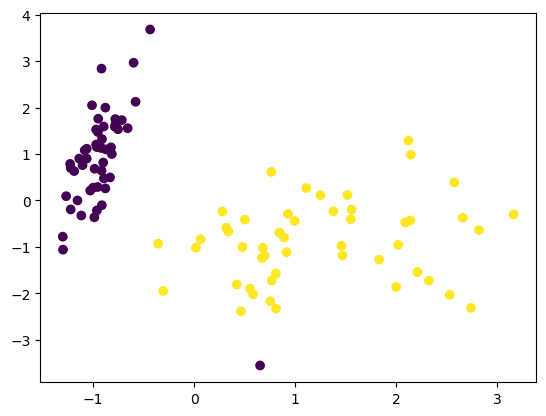

In [38]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=5123)
plt.scatter(X[:, 0], X[:, 1], c=y)

# Variantes de Regresión Lineal (Lasso, Ridge y ElasticNet).
### Ejercicio: implementación de variantes
Elige una de las tres variantes de Regresión Lineal (Lasso, Ridge o ElasticNet) e impleméntala tanto para los problemas de regresión como de clasificación. Por ejemplo, si eliges Lasso tendrías que implementar la clase `MyLassoRegressor` y `MyLassoClassifier`.